In [8]:
import os
import sys
import warnings
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

import matplotlib.font_manager
plt.rcParams["font.family"] = "Arial"

warnings.filterwarnings("ignore")

In [9]:
qcarmen_inds = {
    'IRF7': 6,
    'DDIT4': 13,
    'IFNL3': 21,
    'TRIM25': 9,
    'SSBP3': 5,
    'GAPDH': 1,
    'BST2': 2,
    'OASL': 12,
    'PML': 23,
    'IFNB1': 15,
    'GBP2': 14,
    'ISG15': 24,
    'MOV10': 20,
    'IFNA2': 18,
    'SLC25A28': 11,
    'NAMPT': 22,
    'MX1': 17,
    'IFITM2': 19,
    'ADAR': 8,
    'HPRT1': 4,
    'CD74': 10,
    'IFITM3': 7,
    'TREX1': 3,
    'IFITM1': 16
}

ind_to_gene = {v: k for k, v in qcarmen_inds.items()}

In [10]:
def load_data(filepath):
    """
    Load CSV data from the specified filepath.

    Parameters:
        filepath (str): Path to the CSV file.

    Returns:
        np.ndarray: 2D array of the loaded data.
    """
    res = []
    with open(filepath, "r") as f:
        for line in f:
            res.append([float(x) for x in line.strip().split(",")])
            
    return np.array(res)

def plot_individual_and_average(
    goi, 
    res, 
    target_wells, 
    x_values,
    base=8,
    out_path=None
):
    """
    Plot individual replicates and the averaged data side by side with a shared y-axis.
    The averaged plot includes standard deviations.

    Parameters:
        goi (int): Gene of interest index.
        res (np.ndarray): 2D array of inference results.
        target_wells (np.ndarray): Array of target well indices.
        x_values (np.ndarray): Array of x-axis values (log10 of dilution factors).
        gene_id (int, optional): Identifier for the gene (used in the plot title).
    """
    gene_id = ind_to_gene[goi + 1]
    
    # Extract replicate data
    replicates = []
    for i in range(3):
        replicate = np.exp(res[target_wells + i, goi] - res[target_wells + i, 0])
        replicates.append(np.log10(replicate / replicate[base]))  # Normalize and log10

    replicates = np.array(replicates)[:, :16]  # Ensure correct slicing
    
    replicates = np.concatenate([replicates[:, :base], replicates[:, base + 1:]], axis=1)
    x_values = np.concatenate([x_values[:base], x_values[base + 1:]])

    # Individual Replicates
    fig, axes = plt.subplots(1, 2, figsize=(4.5, 4.5), sharey=True)

    ax1 = axes[0]
    ax1.set_aspect("equal", adjustable="box")
    for replicate in replicates:
        ax1.scatter(
            x_values, 
            replicate, 
            edgecolors='black',
            alpha=0.8,
            s=50
        )
    ax1.plot([-3, 3], [-3, 3], 'k--', alpha=0.5, label="$y=x$")
    ax1.set_xlabel('$\log_{10}$(True Dilution Factor)')
    ax1.set_ylabel('$\log_{10}$(Predicted Dilution Factor)')
    ax1.set_xlim([-3.5, 3.5])
    ax1.set_ylim([-11.5, 4])
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    x_all = np.tile(x_values, replicates.shape[0])
    y_all = replicates.flatten()
    r = linregress(x_all, y_all).rvalue

    ax1.text(
        0.85, 0.05, f"$R$ = {r:.2f}",
        transform=ax1.transAxes, ha='right', va='bottom',
        fontsize=11, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Averaged Plot
    mean_y = replicates.mean(axis=0)
    std_y = replicates.std(axis=0)

    ax2 = axes[1]
    ax2.set_aspect("equal", adjustable="box")
    ax2.scatter(
        x_values, 
        mean_y, 
        edgecolor='black', 
    )
    ax2.errorbar(
        x_values, 
        mean_y, 
        yerr=std_y, 
        fmt='o', 
        color='b', 
        alpha=0.5, 
        elinewidth=1,
        capsize=3,
    )
    
    ax2.plot([-3, 3], [-3, 3], 'k--', alpha=0.5, label="$y=x$")
    ax2.set_xlabel('$\log_{10}$(True Dilution Factor)')
    ax2.set_xlim([-3.5, 3.5])
    ax2.set_ylim([-11.5, 4])
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()

    fig.suptitle(f"{gene_id if gene_id else goi + 1} Dilutions", fontsize=12)

    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    
    if out_path is not None:
        plt.savefig(out_path, format="pdf")
    
    plt.show()

In [11]:
# Filepath to your CSV data
data_filepath = "../outputs/rdod8RF0elsD/inference_results.csv"

# Load data
res = load_data(data_filepath)

# Define target wells
target_wells = np.array(
    [0 + 24 * x for x in range(8)] + [3 + 24 * x for x in range(8)]
)

# Define x-axis values (log10 of dilution factors)
dilution_factors = [400, 200, 100, 50, 25, 10, 5, 2, 1, 1/2, 1/5, 1/10, 1/25, 1/50, 1/100, 1/200]
x = np.log10(dilution_factors)
x_selected = x[:16]  # Assuming 'start=0' and 'end=24'
base=8

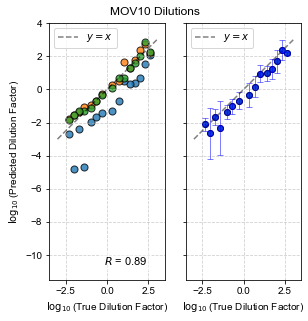

In [12]:
goi = 19

# Plotting
plot_individual_and_average(
    goi, 
    res, 
    target_wells, 
    x_selected, 
    base=base,
    # out_path="./mov10.pdf"
)

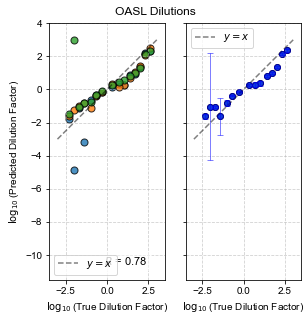

In [13]:
goi = 11

# Plotting
# Plotting
plot_individual_and_average(
    goi, 
    res, 
    target_wells, 
    x_selected, 
    base=base,
    # out_path="./oasl.pdf"
)

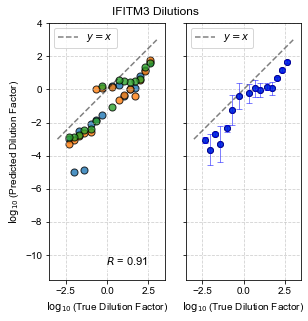

In [14]:
goi = 6

# Plotting
# Plotting
plot_individual_and_average(
    goi, 
    res, 
    target_wells, 
    x_selected, 
    base=base,
    # out_path="./ifitm3.pdf"
)

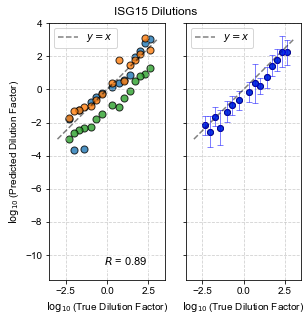

In [15]:
goi = 23

# Plotting
# Plotting
plot_individual_and_average(
    goi, 
    res, 
    target_wells, 
    x_selected, 
    base=base,
    # out_path="./isg15.pdf"
)